In [1]:
# import standard python libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os, subprocess

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams 
rcParams['pdf.fonttype'] = 42 # True font
rcParams['font.size'] =  8  
rcParams['grid.linewidth'] =  0.5 
rcParams['lines.color'] = 'b' 
rcParams['lines.linewidth'] = 1 
rcParams['lines.markersize'] = 3
rcParams['lines.markeredgewidth'] = 0 # set Marker with no edgelinesMerge_insulation_df.loc[P, :]
rcParams['axes.linewidth'] = 0.5
rcParams['axes.titlesize'] = 8
rcParams['axes.labelsize'] = 8
rcParams['xtick.labelsize'] = 8
rcParams['ytick.labelsize'] = 8
rcParams['legend.fontsize'] = 8
rcParams['legend.title_fontsize'] = 8

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Import python package for working with cooler files and tools for analysis
import cooler
import cooltools.lib.plotting

In [4]:
from packaging import version
if version.parse(cooltools.__version__) < version.parse('0.5.4'):
    raise AssertionError("tutorials rely on cooltools version 0.5.4 or higher,"+
                         "please check your cooltools version and update to the latest")

In [7]:
# download test data
import cooltools

In [17]:
pclr = cooler.Cooler('/data3/HG001-pore-c/hg001-dip3d-output/contact_hap-pore-c/paternal/paternal_hg19.mcool::resolutions/50000')
mclr = cooler.Cooler('/data3/HG001-pore-c/hg001-dip3d-output/contact_hap-pore-c/maternal/maternal_hg19.mcool::resolutions/50000')

In [18]:
import bioframe

In [19]:
hg19_genome = bioframe.load_fasta('/data3/HG001-pore-c/hg001-dip3d-output/contact_hap-pore-c/ref/hg19.fa');
pbins = pclr.bins()[:]
mbins = mclr.bins()[:]
## note the next command may require installing pysam
pgc_cov = bioframe.frac_gc(pbins[['chrom', 'start', 'end']], hg19_genome)
mgc_cov = bioframe.frac_gc(mbins[['chrom', 'start', 'end']], hg19_genome)
pgc_cov.to_csv('/data3/HG001-pore-c/hg001-dip3d-output/contact_hap-pore-c/ref/hg19_pgc_cov_50kb.tsv',index=False,sep='\t')
mgc_cov.to_csv('/data3/HG001-pore-c/hg001-dip3d-output/contact_hap-pore-c/ref/hg19_mgc_cov_50kb.tsv',index=False,sep='\t')
pgc_cov = pd.read_csv('/data3/HG001-pore-c/hg001-dip3d-output/contact_hap-pore-c/ref/hg19_pgc_cov_50kb.tsv',header=0, index_col=None, sep='\t')
mgc_cov = pd.read_csv('/data3/HG001-pore-c/hg001-dip3d-output/contact_hap-pore-c/ref/hg19_mgc_cov_50kb.tsv',header=0, index_col=None, sep='\t')

In [57]:
# compartment score bed
pbins.loc[:, ["chrom","start", "end"]].to_csv("/data3/HG001-pore-c/hg001-dip3d-output/contact_hap-pore-c/ref/liftoff/compartment/compartment_score.bed", 
                                             header=False, index=False, sep="\t")

In [20]:
pview_df = pd.DataFrame({'chrom': pclr.chromnames,
                        'start': 0,
                        'end': pclr.chromsizes.values,
                        'name': pclr.chromnames}
                      )

In [21]:
mview_df = pd.DataFrame({'chrom': mclr.chromnames,
                        'start': 0,
                        'end': mclr.chromsizes.values,
                        'name': mclr.chromnames}
                      )

In [22]:
# Calculate eigenvector scores
# obtain first 3 eigenvectors
pcis_eigs = cooltools.eigs_cis(
                        pclr,
                        pgc_cov,
                        view_df=pview_df,
                        n_eigs=3,
                        )

# cis_eigs[0] returns eigenvalues, here we focus on eigenvectors
peigenvector_track = pcis_eigs[1][['chrom','start','end','E1']]

# obtain first 3 eigenvectors
mcis_eigs = cooltools.eigs_cis(
                        mclr,
                        mgc_cov,
                        view_df=mview_df,
                        n_eigs=3,
                        )

# cis_eigs[0] returns eigenvalues, here we focus on eigenvectors
meigenvector_track = mcis_eigs[1][['chrom','start','end','E1']]

# Export
exfile = "/data3/HG001-pore-c/hg001-dip3d-output/contact_hap-pore-c/ipynb/hg001_paternal_compartment_eginvector_scores.csv"
peigenvector_track.to_csv(exfile, header=True, index=False)
exfile = "/data3/HG001-pore-c/hg001-dip3d-output/contact_hap-pore-c/ipynb/hg001_maternal_compartment_eginvector_scores.csv"
meigenvector_track.to_csv(exfile, header=True, index=False)

In [23]:
haplotype_envector_track = peigenvector_track.copy()
haplotype_envector_track.columns = ["chrom", "start", "end", "paternal"]
haplotype_envector_track["maternal"] = meigenvector_track["E1"].values

In [24]:
filter_envector_tract = haplotype_envector_track.loc[ (~haplotype_envector_track['paternal'].isna())&(~haplotype_envector_track['maternal'].isna())]
# Export
exfile = "/data3/HG001-pore-c/hg001-dip3d-output/contact_hap-pore-c/ipynb/hg001_diploid_p_m_compartment_eginvector_scores.csv"
filter_envector_tract.to_csv(exfile, header=True, index=False)

In [13]:
# import standard python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [28]:
# Import python package for working with cooler files and tools for analysis
import cooler
import cooltools.lib.plotting
from cooltools import insulation

from packaging import version
if version.parse(cooltools.__version__) < version.parse('0.5.4'):
    raise AssertionError("tutorials rely on cooltools version 0.5.4 or higher,"+
                         "please check your cooltools version and update to the latest")

In [30]:
resolution = 25000
pclr = cooler.Cooler(f'/data3/HG001-pore-c/hg001-dip3d-output/contact_hap-pore-c/paternal/paternal_hg19.mcool::resolutions/{resolution}')
mclr = cooler.Cooler(f'/data3/HG001-pore-c/hg001-dip3d-output/contact_hap-pore-c/maternal/maternal_hg19.mcool::resolutions/{resolution}')
windows = [2*resolution, 5*resolution, 10*resolution]
pinsulation_table = insulation(pclr, windows, verbose=True)
minsulation_table = insulation(mclr, windows, verbose=True)

INFO:root:fallback to serial implementation.
INFO:root:Processing region chr1
INFO:root:Processing region chr2
INFO:root:Processing region chr3
INFO:root:Processing region chr4
INFO:root:Processing region chr5
INFO:root:Processing region chr6
INFO:root:Processing region chr7
INFO:root:Processing region chr8
INFO:root:Processing region chr9
INFO:root:Processing region chr10
INFO:root:Processing region chr11
INFO:root:Processing region chr12
INFO:root:Processing region chr13
INFO:root:Processing region chr14
INFO:root:Processing region chr15
INFO:root:Processing region chr16
INFO:root:Processing region chr17
INFO:root:Processing region chr18
INFO:root:Processing region chr19
INFO:root:Processing region chr20
INFO:root:Processing region chr21
INFO:root:Processing region chr22
INFO:root:Processing region chrX
INFO:root:Processing region chrY
INFO:root:Processing region chrM
INFO:root:fallback to serial implementation.
INFO:root:Processing region chr1
INFO:root:Processing region chr2
INFO:r

In [33]:
pinsulation_table = pinsulation_table.loc[ pinsulation_table["chrom"].isin( [f"chr{N}" for N in range(1,22+1)] ), : ]
minsulation_table = minsulation_table.loc[ minsulation_table["chrom"].isin( [f"chr{N}" for N in range(1,22+1)] ), : ]
# export
exfile = "/data3/HG001-pore-c/hg001-dip3d-output/contact_hap-pore-c/ipynb/hg001_paternal_insulation_scores.csv"
pinsulation_table.to_csv(exfile, header=True, index=False)
# export
exfile = "/data3/HG001-pore-c/hg001-dip3d-output/contact_hap-pore-c/ipynb/hg001_maternal_insulation_scores.csv"
minsulation_table.to_csv(exfile, header=True, index=False)

In [34]:
pfirst_window_summary = pinsulation_table.columns[[ str(windows[-1]) in i for i in pinsulation_table.columns]]

pinsulation_df = pinsulation_table[['chrom','start','end','region','is_bad_bin']+list(pfirst_window_summary)]

In [35]:
mfirst_window_summary = minsulation_table.columns[[ str(windows[-1]) in i for i in minsulation_table.columns]]

minsulation_df = minsulation_table[['chrom','start','end','region','is_bad_bin']+list(mfirst_window_summary)]

In [ ]:
pinsulation_df

In [36]:
pm_insulation_merge = pd.merge(pinsulation_df[['chrom', 'start', 'end', 'is_bad_bin','log2_insulation_score_250000', 'is_boundary_250000']],
                               minsulation_df[['chrom', 'start', 'end', 'is_bad_bin','log2_insulation_score_250000', 'is_boundary_250000']],
                               on=['chrom', 'start', 'end'])
pm_insulation_merge 

,chrom,start,end,is_bad_bin_x,log2_insulation_score_250000_x,is_boundary_250000_x,is_bad_bin_y,log2_insulation_score_250000_y,is_boundary_250000_y
0,chr1,0,25000,True,NaN,False,True,NaN,False
1,chr1,25000,50000,True,NaN,False,True,NaN,False
2,chr1,50000,75000,True,NaN,False,True,NaN,False
3,chr1,75000,100000,True,NaN,False,True,NaN,False
4,chr1,100000,125000,True,NaN,False,True,NaN,False
...,...,...,...,...,...,...,...,...,...
115249,chr22,51200000,51225000,False,1.317793,False,False,1.21652,False
115250,chr22,51225000,51250000,True,NaN,False,True,NaN,False
115251,chr22,51250000,51275000,True,NaN,False,True,NaN,False
115252,chr22,51275000,51300000,True,NaN,False,True,NaN,False


In [80]:
pm_insulation_merge.loc[:, ["chrom","start","end"] ].to_csv("/data3/HG001-pore-c/hg001-dip3d-output/contact_hap-pore-c/ref/liftoff/insulation/insulation.bed",
                                                           header=False, index=False, sep="\t")

In [39]:
# AES genes
pgene = pd.read_table("/data3/HG001-pore-c/hg001-dip3d-output/contact_hap-pore-c/ref/paternal_gene.txt")
mgene = pd.read_table("/data3/HG001-pore-c/hg001-dip3d-output/contact_hap-pore-c/ref/maternal_gene.txt")

In [37]:
# ref_gene = pd.read_table("/data3/HG001-pore-c/hg001-dip3d-output/contact_hap-pore-c/ref/GRch38_GENCODE_V29_merge_annotations_gtf.ENCFF159KBI.gtf",
#                          header=None)
ref_gene = pd.read_csv("/data3/HG001-pore-c/hg001-dip3d-output/contact_hap-pore-c/ref/gencode.v29lift37.annotation.gtf.gz",
                         header=None,sep="\t", skiprows=5)
ref_gene.head()

,0,1,2,3,4,5,6,7,8
0,chr1,HAVANA,gene,11869,14409,.,+,.,"gene_id ""ENSG00000223972.5_2""; gene_type ""tran..."
1,chr1,HAVANA,transcript,11869,14409,.,+,.,"gene_id ""ENSG00000223972.5_2""; transcript_id ""..."
2,chr1,HAVANA,exon,11869,12227,.,+,.,"gene_id ""ENSG00000223972.5_2""; transcript_id ""..."
3,chr1,HAVANA,exon,12613,12721,.,+,.,"gene_id ""ENSG00000223972.5_2""; transcript_id ""..."
4,chr1,HAVANA,exon,13221,14409,.,+,.,"gene_id ""ENSG00000223972.5_2""; transcript_id ""..."


In [40]:
ref_gene = ref_gene.loc[ref_gene[2]=='gene']
ref_gene['geneid'] = ref_gene[8].str.split('"', expand=True)[1]
ref_gene["ENSG"] = ref_gene['geneid'].str.split(".", expand=True)[0]
pout = ref_gene.loc[ref_gene['ENSG'].isin(pgene['index'])]
mout = ref_gene.loc[ref_gene['ENSG'].isin(mgene['index'])]

tss_region_size = 1000
pout['tss_start'] = pout.apply(lambda row: row[3] - tss_region_size if row[6] == '+' 
                            else row[4] - tss_region_size, axis=1)
pout['tss_end'] = pout.apply(lambda row: row[3] + tss_region_size if row[6] == '+' 
                           else row[4] + tss_region_size, axis=1)

mout['tss_start'] = mout.apply(lambda row: row[3] - tss_region_size if row[6] == '+' 
                            else row[4] - tss_region_size, axis=1)
mout['tss_end'] = mout.apply(lambda row: row[3] + tss_region_size if row[6] == '+' 
                           else row[4] + tss_region_size, axis=1)

pout[[0,'tss_start','tss_end']].to_csv("/data3/HG001-pore-c/hg001-dip3d-output/contact_hap-pore-c/ref/pgene_hg19.bed",
                                                                    index=None, header=None, sep="\t")
mout[[0,'tss_start','tss_end']].to_csv("/data3/HG001-pore-c/hg001-dip3d-output/contact_hap-pore-c/ref/mgene_hg10.bed",
                                                                    index=None, header=None, sep="\t")

In [41]:
hg19pgene = pd.read_table("/data3/HG001-pore-c/hg001-dip3d-output/contact_hap-pore-c/ref/liftoff/pgene_hg19.bed",
                          header=None)
hg19mgene = pd.read_table("/data3/HG001-pore-c/hg001-dip3d-output/contact_hap-pore-c/ref/liftoff/mgene_hg19.bed",
                          header=None)

In [42]:
hg19pgene['mid'] = hg19pgene[2] - hg19pgene[1]
hg19mgene['mid'] = hg19mgene[2] - hg19mgene[1]

In [58]:
%%bash
cd /data3/HG001-pore-c/hg001-dip3d-output/contact_hap-pore-c/ref/liftoff/compartment
bedtools intersect -a compartment_score.bed -b pgene_hg19.bed -wao > pgene_hg19_compartment.txt
bedtools intersect -a compartment_score.bed -b mgene_hg19.bed -wao > mgene_hg19_compartment.txt

In [59]:
hg19pgene_compart = pd.read_table("/data3/HG001-pore-c/hg001-dip3d-output/contact_hap-pore-c/ref/liftoff/compartment/pgene_hg19_compartment.txt",
                          header=None)
hg19mgene_compart = pd.read_table("/data3/HG001-pore-c/hg001-dip3d-output/contact_hap-pore-c/ref/liftoff/compartment/mgene_hg19_compartment.txt",
                          header=None)

In [60]:
hg19pgene_compart

,0,1,2,3,4,5,6,7
0,chr1,0,50000,.,-1,-1,.,0
1,chr1,50000,100000,.,-1,-1,.,0
2,chr1,100000,150000,.,-1,-1,.,0
3,chr1,150000,200000,.,-1,-1,.,0
4,chr1,200000,250000,.,-1,-1,.,0
...,...,...,...,...,...,...,...,...
61930,chrY,59200000,59250000,.,-1,-1,.,0
61931,chrY,59250000,59300000,.,-1,-1,.,0
61932,chrY,59300000,59350000,.,-1,-1,.,0
61933,chrY,59350000,59373566,.,-1,-1,.,0


In [61]:
tmp1 = hg19pgene_compart.loc[hg19pgene_compart[3]!="."].copy()
tmp2 = hg19mgene_compart.loc[hg19mgene_compart[3]!="."].copy()

In [62]:
tmp1 = tmp1.sort_values(7, ascending=False).drop_duplicates([3,4,5])
tmp2 = tmp2.sort_values(7, ascending=False).drop_duplicates([3,4,5])

In [397]:
# def norm(df, col1, col2):
#     min_value = df[col1].min()
#     max_value = df[col1].max()
    
#     # 将数值归一化到0和1之间
#     normalized_values = [2*((x - min_value) / (max_value - min_value))-1 for x in df[col1].tolist()]
#     df[col2] = normalized_values

# norm(peigenvector_track, 'E1', 'PE1_norm')
# norm(meigenvector_track, 'E1', 'ME1_norm')

In [453]:
# exfile="/data3/HG001-pore-c/hg001-dip3d-output/contact_hap-pore-c/ipynb/hg001_paternal_compartment_eginvector_scores.csv"
# peigenvector_track.to_csv(exfile, header=True, index=False)

# exfile="/data3/HG001-pore-c/hg001-dip3d-output/contact_hap-pore-c/ipynb/hg001_maternal_compartment_eginvector_scores.csv"
# meigenvector_track.to_csv(exfile, header=True, index=False)

In [63]:
P_plot = pd.merge(tmp1, peigenvector_track,
                  left_on=[0,1,2], right_on=['chrom', 'start', 'end'])
P_plot = pd.merge(P_plot, meigenvector_track,
                  left_on=[0,1,2], right_on=['chrom', 'start', 'end'])

In [64]:
M_plot = pd.merge(tmp2, peigenvector_track,
                  left_on=[0,1,2], right_on=['chrom', 'start', 'end'])
M_plot = pd.merge(M_plot, meigenvector_track,
                  left_on=[0,1,2], right_on=['chrom', 'start', 'end'])

In [49]:
savepath = "/data3/HG001-pore-c/hg001-dip3d-output/contact_hap-pore-c/Figure"

In [65]:
P_plot

,0,1,2,3,4,5,6,7,chrom_x,start_x,end_x,E1_x,chrom_y,start_y,end_y,E1_y
0,chr5,96200000,96250000,chr5,96210642,96212643,2001,2001,chr5,96200000,96250000,0.925858,chr5,96200000,96250000,0.884305
1,chr1,7800000,7850000,chr1,7843380,7845380,2000,2000,chr1,7800000,7850000,0.626228,chr1,7800000,7850000,0.707116
2,chr19,52400000,52450000,chr19,52429400,52431400,2000,2000,chr19,52400000,52450000,-1.162113,chr19,52400000,52450000,-1.160782
3,chr19,21300000,21350000,chr19,21323827,21325827,2000,2000,chr19,21300000,21350000,-0.686903,chr19,21300000,21350000,-0.812007
4,chr19,21250000,21300000,chr19,21263965,21265965,2000,2000,chr19,21250000,21300000,-0.639622,chr19,21250000,21300000,-0.884363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,chr3,49400000,49450000,chr3,49448639,49450639,2000,1361,chr3,49400000,49450000,NaN,chr3,49400000,49450000,NaN
90,chr16,66600000,66650000,chr16,66599296,66601296,2000,1296,chr16,66600000,66650000,0.180964,chr16,66600000,66650000,0.262228
91,chr8,27850000,27900000,chr8,27849244,27851244,2000,1244,chr8,27850000,27900000,0.792337,chr8,27850000,27900000,0.740199
92,chr3,184950000,185000000,chr3,184998778,185000778,2000,1222,chr3,184950000,185000000,0.998232,chr3,184950000,185000000,0.998118


皮尔森相关系数: 0.9819761581453776
对应的 p 值: 6.514746742855903e-67


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 29 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'P', 'a', 'c', 'colon', 'e', 'eight', 'g', 'hyphen', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'space', 't', 'two', 'v', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 17, 19, 20, 21, 27, 28, 29, 51, 68, 70, 72, 74, 76, 79, 80, 81, 82, 83, 85, 86, 87, 89]
INFO:fontTools.subset:Closed glyph list over 'MATH': 35 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'P', 'a', 'c', 'colon', 'e',

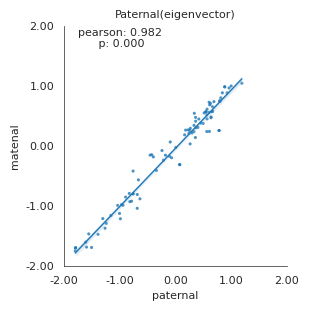

In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
from scipy.stats import pearsonr

# 设置 Seaborn 的样式
sns.set_style("white")

# 假设 M_plot 已经被定义和加载
# 筛选出非空的数据点
valid_data = P_plot.dropna(subset=['E1_x', 'E1_y'])

# 从有效数据中提取 x 和 y 值
v1 = valid_data['E1_x']
v2 = valid_data['E1_y']

# 将 v1 和 v2 转换为 DataFrame
data = pd.DataFrame({
    'E1_x': v1,
    'E1_y': v2
})
corr, p_value = pearsonr(v1, v2)

print(f"皮尔森相关系数: {corr}")
print(f"对应的 p 值: {p_value}")
# 计算用于设置坐标轴界限的最大值
max_v = math.ceil(max(v1.max(), v2.max(), abs(v1.min()), abs(v2.min())))

# 绘制线性回归图
g = sns.lmplot(x="E1_x", y="E1_y", data=data, scatter_kws={"s": 5, "edgecolor": "none"}, line_kws={"linewidth": 1}, height=3)

# 获取当前的坐标对象
ax = plt.gca()

# 设置横坐标的刻度范围和标记
ax.set_xlim(-max_v, max_v)
ax.set_xticks(range(-max_v, max_v+1, 1))
ax.set_xticklabels([f"{i} $" for i in range(-max_v, max_v+1, 1)])

# # 设置纵坐标的刻度范围和标记
ax.set_ylim(-max_v, max_v)
ax.set_yticks(range(-max_v, max_v+1, 1))
ax.set_yticklabels([f"{i} $" for i in range(-max_v, max_v+1, 1)])
ax.set_xlabel("paternal")
ax.set_ylabel("matenal")
# 设置坐标轴格式化
formatter = ticker.StrMethodFormatter("{x:,.2f}")  # 使用千位分隔符，并保留两位小数
g.ax.xaxis.set_major_formatter(formatter)
g.ax.yaxis.set_major_formatter(formatter)
plt.text(-1, 1.8, f"pearson: {corr:.3f}\n p: {p_value:.3f}", fontsize=8, ha='center', va='center')
# 显示图形
plt.title("Paternal(eigenvector)")
plt.savefig(f"{savepath}/paternal_eigenvector-50kb.pdf")
plt.show()

皮尔森相关系数: 0.9742654805506531
对应的 p 值: 1.2721103906946712e-36


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 30 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'M', 'a', 'c', 'colon', 'e', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'seven', 'space', 't', 'two', 'v', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 17, 19, 20, 21, 23, 26, 28, 29, 48, 68, 70, 72, 74, 76, 79, 80, 81, 82, 83, 85, 86, 87, 89]
INFO:fontTools.subset:Closed glyph list over 'MATH': 36 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'M', 'a', 'c', '

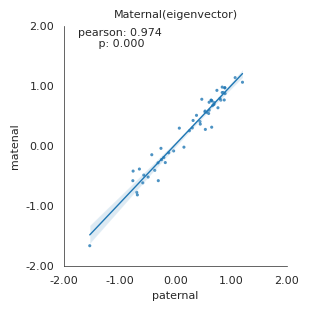

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math

# 设置 Seaborn 的样式
sns.set_style("white")

# 假设 M_plot 已经被定义和加载
# 筛选出非空的数据点
valid_data = M_plot.dropna(subset=['E1_x', 'E1_y'])

# 从有效数据中提取 x 和 y 值
v1 = valid_data['E1_x']
v2 = valid_data['E1_y']

# 将 v1 和 v2 转换为 DataFrame
data = pd.DataFrame({
    'E1_x': v1,
    'E1_y': v2
})
corr, p_value = pearsonr(v1, v2)

print(f"皮尔森相关系数: {corr}")
print(f"对应的 p 值: {p_value}")
# 计算用于设置坐标轴界限的最大值
max_v = math.ceil(max(v1.max(), v2.max(), abs(v1.min()), abs(v2.min())))

# 绘制线性回归图
g = sns.lmplot(x="E1_x", y="E1_y", data=data, scatter_kws={"s": 5, "edgecolor": "none"}, line_kws={"linewidth": 1}, height=3)

# 获取当前的坐标对象
ax = plt.gca()

# 设置横坐标的刻度范围和标记
ax.set_xlim(-max_v, max_v)
ax.set_xticks(range(-max_v, max_v+1, 1))
ax.set_xticklabels([f"{i} $" for i in range(-max_v, max_v+1, 1)])

# # 设置纵坐标的刻度范围和标记
ax.set_ylim(-max_v, max_v)
ax.set_yticks(range(-max_v, max_v+1, 1))
ax.set_yticklabels([f"{i} $" for i in range(-max_v, max_v+1, 1)])
ax.set_xlabel("paternal")
ax.set_ylabel("matenal")
# 设置坐标轴格式化
formatter = ticker.StrMethodFormatter("{x:,.2f}")  # 使用千位分隔符，并保留两位小数
g.ax.xaxis.set_major_formatter(formatter)
g.ax.yaxis.set_major_formatter(formatter)
plt.text(-1, 1.8, f"pearson: {corr:.3f}\n p: {p_value:.3f}", fontsize=8, ha='center', va='center')
# 显示图形
plt.title("Maternal(eigenvector)")
plt.savefig(f"{savepath}/maternal_eigenvector_50kb.pdf")
plt.show()

In [82]:
%%bash
## insulation overlap
cd /data3/HG001-pore-c/hg001-dip3d-output/contact_hap-pore-c/ref/liftoff/insulation
bedtools intersect -a insulation.bed -b pgene_hg19.bed -wao > pgene_hg19_insulation.txt
bedtools intersect -a insulation.bed -b mgene_hg19.bed -wao > mgene_hg19_insulation.txt

In [104]:
P_insulation = pinsulation_df[['chrom', 'start', 'end', 'log2_insulation_score_250000', 'is_boundary_250000']].copy()
M_insulation = minsulation_df[['chrom', 'start', 'end', 'log2_insulation_score_250000', 'is_boundary_250000']].copy()
hg19pgene_insulation = pd.read_table("/data3/HG001-pore-c/hg001-dip3d-output/contact_hap-pore-c/ref/liftoff/insulation/pgene_hg19_insulation.txt",
                          header=None)
hg19mgene_insulation = pd.read_table("/data3/HG001-pore-c/hg001-dip3d-output/contact_hap-pore-c/ref/liftoff/insulation/mgene_hg19_insulation.txt",
                          header=None)

In [105]:
tmp1 = hg19pgene_insulation.loc[hg19pgene_insulation[3]!="."].copy()
tmp2 = hg19mgene_insulation.loc[hg19mgene_insulation[3]!="."].copy()

In [106]:
tmp1 = tmp1.sort_values(7, ascending=False).drop_duplicates([3,4,5])
tmp2 = tmp2.sort_values(7, ascending=False).drop_duplicates([3,4,5])

In [113]:
P_plot = pd.merge(tmp1, P_insulation,
                  left_on=[0,1,2], right_on=['chrom', 'start', 'end'])
P_plot = pd.merge(P_plot, M_insulation,
                  left_on=[0,1,2], right_on=['chrom', 'start', 'end'])

In [116]:
valid_data

,0,1,2,3,4,5,6,7,chrom_x,start_x,end_x,log2_insulation_score_250000_x,is_boundary_250000_x,chrom_y,start_y,end_y,log2_insulation_score_250000_y,is_boundary_250000_y
0,chr5,96200000,96225000,chr5,96210642,96212643,2001,2001,chr5,96200000,96225000,0.702353,False,chr5,96200000,96225000,0.659831,False
1,chr1,7825000,7850000,chr1,7843380,7845380,2000,2000,chr1,7825000,7850000,-0.050720,False,chr1,7825000,7850000,-0.011950,False
2,chr19,52425000,52450000,chr19,52429400,52431400,2000,2000,chr19,52425000,52450000,-0.231494,False,chr19,52425000,52450000,-0.195996,False
3,chr19,21250000,21275000,chr19,21263965,21265965,2000,2000,chr19,21250000,21275000,-0.043371,False,chr19,21250000,21275000,-0.271736,False
4,chr19,10325000,10350000,chr19,10340962,10342962,2000,2000,chr19,10325000,10350000,0.358026,False,chr19,10325000,10350000,0.346319,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,chr8,135725000,135750000,chr8,135724292,135726292,2000,1292,chr8,135725000,135750000,0.059353,False,chr8,135725000,135750000,0.255369,False
90,chr8,27850000,27875000,chr8,27849244,27851244,2000,1244,chr8,27850000,27875000,0.364527,False,chr8,27850000,27875000,0.404554,False
91,chr3,184975000,185000000,chr3,184998778,185000778,2000,1222,chr3,184975000,185000000,0.140288,False,chr3,184975000,185000000,0.109187,False
92,chr19,21300000,21325000,chr19,21323827,21325827,2000,1173,chr19,21300000,21325000,-0.090116,False,chr19,21300000,21325000,-0.260487,False


In [114]:
P_plot[['log2_insulation_score_250000_x', 'log2_insulation_score_250000_y']].corr()

,log2_insulation_score_250000_x,log2_insulation_score_250000_y
log2_insulation_score_250000_x,1.000000,0.973027
log2_insulation_score_250000_y,0.973027,1.000000


In [109]:
test = P_plot.dropna().copy()
test[['log2_insulation_score_250000_x', 'log2_insulation_score_250000_y']].corr()

,log2_insulation_score_250000_x,log2_insulation_score_250000_y
log2_insulation_score_250000_x,1.000000,0.973027
log2_insulation_score_250000_y,0.973027,1.000000


In [110]:
P_plot = pd.merge(tmp2, P_insulation,
                  left_on=[0,1,2], right_on=['chrom', 'start', 'end'])
M_plot = pd.merge(P_plot, M_insulation,
                  left_on=[0,1,2], right_on=['chrom', 'start', 'end'])

In [111]:
corr, p_value = pearsonr(test['log2_insulation_score_250000_x'], test['log2_insulation_score_250000_y'])

皮尔森相关系数: 0.9730266202764501
对应的 p 值: 9.309955358008974e-60


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 28 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'P', 'a', 'colon', 'e', 'five', 'hyphen', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'seven', 'space', 't', 'three', 'u', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 17, 19, 20, 22, 24, 26, 28, 29, 51, 68, 72, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88]
INFO:fontTools.subset:Closed glyph list over 'MATH': 34 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'P', 'a', 'colon', 'e', 'five', 

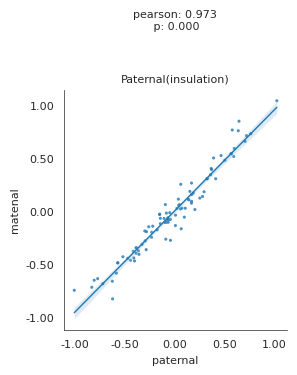

In [115]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math

# 设置 Seaborn 的样式
sns.set_style("white")

# 假设 M_plot 已经被定义和加载
# 筛选出非空的数据点
valid_data = P_plot.dropna(subset=['log2_insulation_score_250000_x', 'log2_insulation_score_250000_y'])

# 从有效数据中提取 x 和 y 值
v1 = valid_data['log2_insulation_score_250000_x']
v2 = valid_data['log2_insulation_score_250000_y']

# 将 v1 和 v2 转换为 DataFrame
data = pd.DataFrame({
    'log2_insulation_score_250000_x': v1,
    'log2_insulation_score_250000_y': v2
})
corr, p_value = pearsonr(v1, v2)

print(f"皮尔森相关系数: {corr}")
print(f"对应的 p 值: {p_value}")
# 计算用于设置坐标轴界限的最大值
max_v = math.ceil(max(v1.max(), v2.max(), abs(v1.min()), abs(v2.min())))

# 绘制线性回归图
g = sns.lmplot(x="log2_insulation_score_250000_x", y="log2_insulation_score_250000_y", data=data, scatter_kws={"s": 5, "edgecolor": "none"}, line_kws={"linewidth": 1}, height=3)

# 获取当前的坐标对象
ax = plt.gca()

# 设置横坐标的刻度范围和标记
# ax.set_xlim(min_v, max_v)
# ax.set_xticks(range(min_v, max_v+1, 1))
# ax.set_xticklabels([f"{i} $" for i in range(min_v, max_v+1, 1)])

# # # 设置纵坐标的刻度范围和标记
# ax.set_ylim(min_v, max_v)
# ax.set_yticks(range(min_v, max_v+1, 1))
# ax.set_yticklabels([f"{i} $" for i in range(min_v, max_v+1, 1)])
ax.set_xlabel("paternal")
ax.set_ylabel("matenal")
# 设置坐标轴格式化
formatter = ticker.StrMethodFormatter("{x:,.2f}")  # 使用千位分隔符，并保留两位小数
g.ax.xaxis.set_major_formatter(formatter)
g.ax.yaxis.set_major_formatter(formatter)
plt.text(-0., 1.8, f"pearson: {corr:.3f}\n p: {p_value:.3f}", fontsize=8, ha='center', va='center')
# 显示图形
plt.title("Paternal(insulation)")
plt.savefig(f"{savepath}/paternal_insulation_25kb.pdf")
plt.show()

皮尔森相关系数: 0.9753082145950749
对应的 p 值: 2.0212894628381757e-38


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 29 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'M', 'a', 'colon', 'e', 'five', 'hyphen', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'seven', 'space', 't', 'three', 'two', 'u', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 17, 19, 20, 21, 22, 24, 26, 28, 29, 48, 68, 72, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88]
INFO:fontTools.subset:Closed glyph list over 'MATH': 35 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'M', 'a', 'colon', 'e

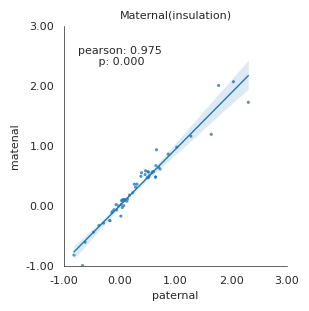

In [99]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math

# 设置 Seaborn 的样式
sns.set_style("white")

# 假设 M_plot 已经被定义和加载
# 筛选出非空的数据点
valid_data = M_plot.dropna(subset=['log2_insulation_score_250000_x', 'log2_insulation_score_250000_y'])

# 从有效数据中提取 x 和 y 值
v1 = valid_data['log2_insulation_score_250000_x']
v2 = valid_data['log2_insulation_score_250000_y']

# 将 v1 和 v2 转换为 DataFrame
data = pd.DataFrame({
    'log2_insulation_score_250000_x': v1,
    'log2_insulation_score_250000_y': v2
})
corr, p_value = pearsonr(v1, v2)

print(f"皮尔森相关系数: {corr}")
print(f"对应的 p 值: {p_value}")
# 计算用于设置坐标轴界限的最大值
max_v = math.ceil(max(v1.max(), v2.max(), ))
min_v = math.floor(min(v1.min(), v2.min()))
# 绘制线性回归图
g = sns.lmplot(x="log2_insulation_score_250000_x", y="log2_insulation_score_250000_y", data=data, scatter_kws={"s": 5, "edgecolor": "none"}, line_kws={"linewidth": 1}, height=3)

# 获取当前的坐标对象
ax = plt.gca()

# 设置横坐标的刻度范围和标记
ax.set_xlim(min_v, max_v)
ax.set_xticks(range(min_v, max_v+1, 1))
ax.set_xticklabels([f"{i} $" for i in range(min_v, max_v+1, 1)])

# # 设置纵坐标的刻度范围和标记
ax.set_ylim(min_v, max_v)
ax.set_yticks(range(min_v, max_v+1, 1))
ax.set_yticklabels([f"{i} $" for i in range(min_v, max_v+1, 1)])
ax.set_xlabel("paternal")
ax.set_ylabel("matenal")
# 设置坐标轴格式化
formatter = ticker.StrMethodFormatter("{x:,.2f}")  # 使用千位分隔符，并保留两位小数
g.ax.xaxis.set_major_formatter(formatter)
g.ax.yaxis.set_major_formatter(formatter)
plt.text(-0, 2.5, f"pearson: {corr:.3f}\n p: {p_value:.3f}", fontsize=8, ha='center', va='center')
plt.title("Maternal(insulation)")
# 显示图形
plt.savefig(f"{savepath}/maternal_insulation_25kb.pdf")
plt.show()